In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import datasets
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print(f'Number of training examples: {x_train.shape[0]}')
print(f'Number of testing examples: {x_test.shape[0]}')
print(f'Shape of the images: {x_train.shape[1:]}')
print(f'Number of classes: {len(np.unique(y_train))}')

Number of training examples: 50000
Number of testing examples: 10000
Shape of the images: (32, 32, 3)
Number of classes: 10


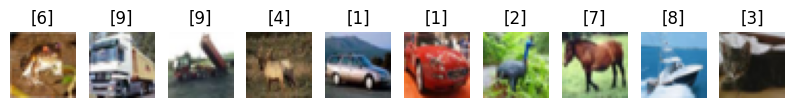

In [3]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize*4))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(x_train[i])
    plt.title(f'{y_train[i]}')

In [4]:
images = x_train.reshape(x_train.shape[0], -1)
print(f'Shape of the images: {images.shape}')

Shape of the images: (50000, 3072)


In [5]:
%%time
c = np.nan_to_num(np.corrcoef(images.T))
c.shape, c.min(), c.max()

CPU times: total: 37 s
Wall time: 3.47 s


((3072, 3072), -0.0964828788108551, 1.0)

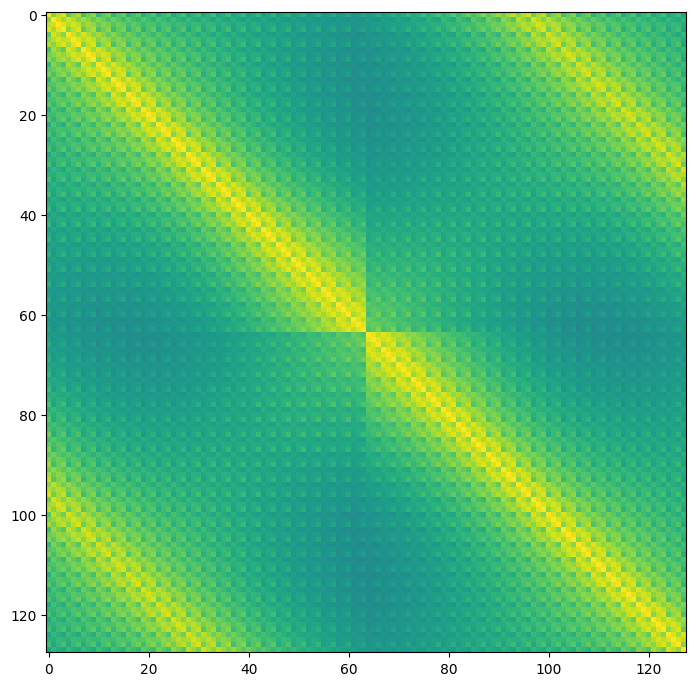

In [6]:
side_dim = 3072

viewport_size = 128  # size of viewpoint
viewport_x = side_dim // 2 - viewport_size // 2  # original position of viewport on x-axis
viewport_y = side_dim // 2 - viewport_size // 2  # original position of viewport on y-axis
# Tạo plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
implot = ax.imshow(c[viewport_y:viewport_y + viewport_size, viewport_x:viewport_x + viewport_size],
                   interpolation='nearest', clim=(-1, 1))
text = ax.text(-.5, -1, "", va="bottom", ha="left")

def onmotion(event):
    global viewport_x
    global viewport_y
    global implot
    global data
    global text
    x = int(np.rint(event.xdata))
    y = int(np.rint(event.ydata))
    if x >= 0 and y >= 0 and x < side_dim and y < side_dim:
        viewport_x = max(0, min(side_dim - viewport_size, x - viewport_size // 2))
        viewport_y = max(0, min(side_dim - viewport_size, y - viewport_size // 2))
        implot.set_array(c[viewport_y:viewport_y + viewport_size, viewport_x:viewport_x + viewport_size])

cid = implot.figure.canvas.mpl_connect('motion_notify_event', onmotion)
plt.show()

#### **First PCs for CIFAR10**

In [7]:
# PCA for dimensionality reduction (adjust n_components as needed)
n_components = 10  # Number of principal components to retain
pca = PCA(n_components=200)
pca.fit(images)


PCA(n_components=200)

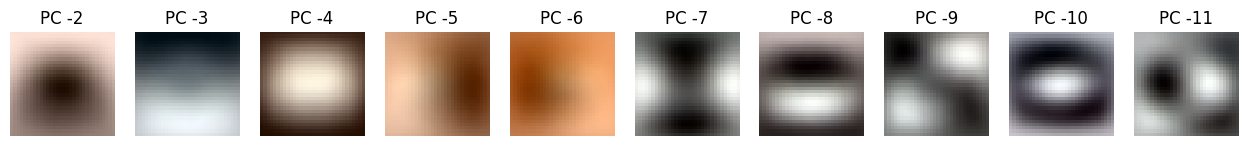

In [8]:
fig = plt.figure(figsize=(n_components * np.power(n_components, 1 / 5), 3))
axes = []

for i in range(1, n_components + 1):
    ax_ = fig.add_subplot(1, n_components, i)
    component_image = pca.components_[i - 1].reshape(32, 32, 3)
    component_image = component_image.astype(np.float32)

    # Normalize the image to a range suitable for imshow
    component_image = (component_image - component_image.min()) / (component_image.max() - component_image.min())

    # Convert to RGB format (if necessary)
    component_image = cv2.cvtColor(component_image, cv2.COLOR_BGR2RGB)
    ax_.imshow(component_image, interpolation='nearest', clim=(-.15, .15));
    ax_.set_title(f'PC {-i-1}')
    ax_.axis('off')
    axes.append(ax_)

Max of mean: 0.5500738039215687


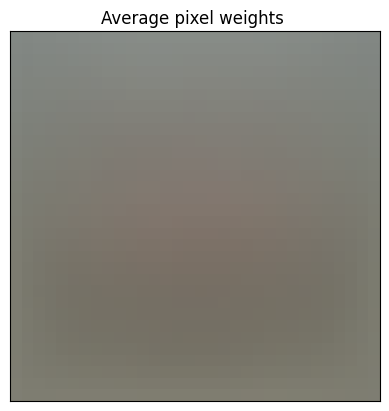

In [9]:
# Show average pixel weights (optional)
fig = plt.figure()
ax = fig.add_subplot(111)

# Normalize the average pixel weights
avg_image = images.mean(axis=0).reshape(32, 32, 3) / 255.0  # Normalize by 255 (assuming uint8 data)

ax.matshow(avg_image, cmap=cm.binary)
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.title('Average pixel weights ')

print("Max of mean:", avg_image.max())
plt.show()

#### **Effect of Iterative PCs**

In [10]:
# We will apply a Fibonacci sequence for illustrative purposes.
def fib(n):
    a, b = 1, 2  # Normally we'd start at 0, 1, but we don't want that...
    for _ in range(n):
        yield a
        a, b = b, a + b

(15, 3072)


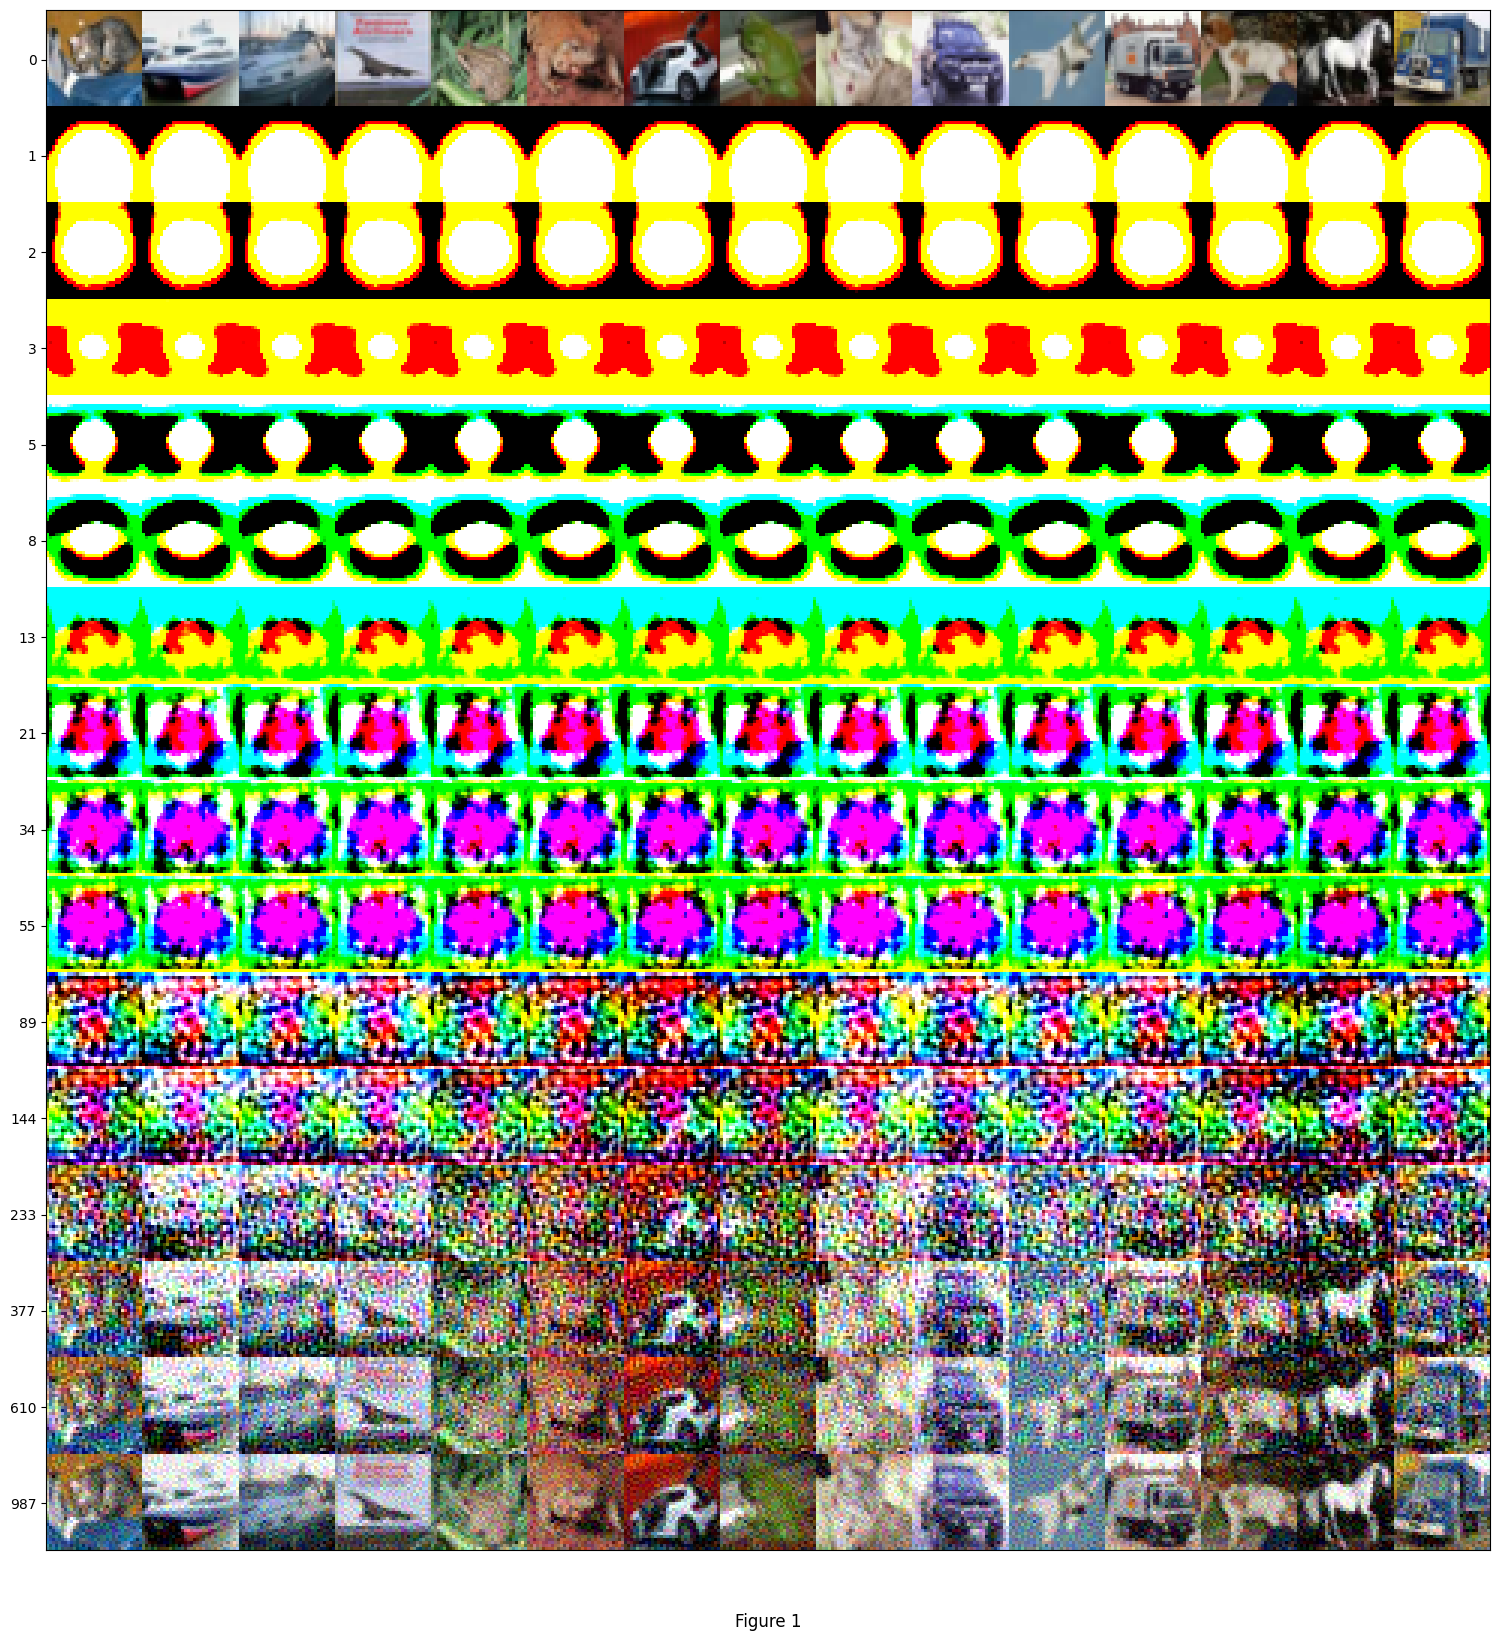

In [11]:
n_images = 15
train_images = x_train.reshape(x_train.shape[0], -1)
test_images = x_test[:n_images].reshape(n_images, -1)
print(test_images.shape)
test_images = test_images.astype('float32') / 255.0  # Normalize pixel values

# define number of components
n_components = 15

# Plot the first ten test images and the corresponding outputs
fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111)

images_in = [test_images[j].reshape(32, 32, 3) for j in range(n_images)]
image = np.concatenate(images_in, axis= 1)

for i in fib(n_components):
    pca = PCA(n_components=i)
    pca.fit(train_images)
    test_outputs = pca.inverse_transform(pca.transform(test_images))

    # Clip pixel values to ensure they are within the valid range
    test_outputs = np.clip(test_outputs, 0, 1)

    images_out = [test_outputs[j].reshape(32, 32, 3) for j in range(n_images)]
    image_out = np.concatenate(images_out, axis=1)
    image = np.concatenate([image, image_out], axis= 0)

# ax.matshow(image, cmap = cm.binary)
ax.imshow(image)
ax.set_xticks(np.array([]))
y_lim = ax.get_ylim()
y_scale = (y_lim[0] - y_lim[1]) / (n_components + 1)
ax.set_yticks(np.linspace(.5, n_components + .5, n_components + 1) * y_scale)
a = [0]
a.extend(list(fib(n_components)))
ax.set_yticklabels(a)
# ax.set_yticklabels([0] + list(range(1, n_components + 1)))
ax.text(0.5, -0.05, "Figure 1", transform=ax.transAxes, ha='center', fontsize=12)


plt.show()

In [12]:
def draw_apply_PC0(idx):
    fig = plt.figure(figsize=(5,3))
    pca0_applied = pca.components_[0].reshape(32,32,3) * pca.transform(test_images)[idx][0]
    image = pca.mean_.reshape(32,32,3) + pca0_applied

    absmin = np.min([test_images[idx].min(), pca.mean_.min(), pca0_applied.min(), image.min()])
    absmax = np.max([test_images[idx].max(), pca.mean_.max(), pca0_applied.max(), image.max()])

    ax_ = fig.add_subplot(1, 4, 1)
    ax_.imshow(test_images[idx].reshape(32,32,3), interpolation='nearest', clim=(absmin, absmax), cmap = 'viridis');
    ax_.set_title(f'original')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 2)
    ax_.imshow(pca.mean_.reshape(32,32,3), interpolation='nearest', clim=(absmin, absmax), cmap = 'viridis');
    ax_.set_title(f'mean')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 3)
    ax_.imshow(pca0_applied, interpolation='nearest', clim=(absmin, absmax), cmap = 'viridis');
    ax_.set_title(f'PC 1')
    ax_.axis('off')

    ax_ = fig.add_subplot(1, 4, 4)
    ax_.imshow(image, interpolation='nearest', clim=(absmin, absmax), cmap = 'viridis');
    ax_.set_title(f'Applied')
    ax_.axis('off')

    print(f'PC_0 min: {pca.components_[0].min():.4f},\tPC_0 max: {pca.components_[0].max():.4f}')
    print(f'mean_img min: {pca.mean_.min():.4f},\tmean_img max: {pca.mean_.max():.4f}')
    print(f'Ammount to apply_{idx}: {pca.transform(test_images)[idx][0]:.4f}')

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(pca.transform(test_images[idx].reshape(1, -1)).flatten())
    ax.axhline(0, lw=.5, color='k') # horizontal lines

    ax.set_title('Amount of each PC applied.')

In [13]:
n_images = 1500
test_images = x_test[:n_images].reshape((n_images, -1))
test_images = test_images.astype('float32') / 255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [99.99506..140.26882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-193.15160132768952..1.003332425045995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-63.57080543767418..127.218072425046].


PC_0 min: -0.0002,	PC_0 max: 0.0315
mean_img min: 99.9951,	mean_img max: 140.2688
Ammount to apply_1: -6126.6248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [99.99506..140.26882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-193.65399321438082..1.0059421164310656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-64.06954841097138..127.22068211643108].


PC_0 min: -0.0002,	PC_0 max: 0.0315
mean_img min: 99.9951,	mean_img max: 140.2688
Ammount to apply_127: -6142.5603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [99.99506..140.26882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-193.4161582898245..1.0047066749955533].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-63.833440900939024..127.21944667499557].


PC_0 min: -0.0002,	PC_0 max: 0.0315
mean_img min: 99.9951,	mean_img max: 140.2688
Ammount to apply_242: -6135.0163


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [99.99506..140.26882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-193.6088262127971..1.0057074949372775].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-64.02470946101712..127.22044749493729].


PC_0 min: -0.0002,	PC_0 max: 0.0315
mean_img min: 99.9951,	mean_img max: 140.2688
Ammount to apply_303: -6141.1276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [99.99506..140.26882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-193.49541592850747..1.005118381438972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-63.91212288490496..127.21985838143898].


PC_0 min: -0.0002,	PC_0 max: 0.0315
mean_img min: 99.9951,	mean_img max: 140.2688
Ammount to apply_444: -6137.5303


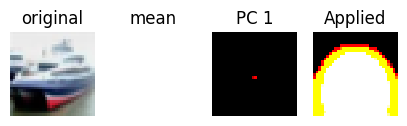

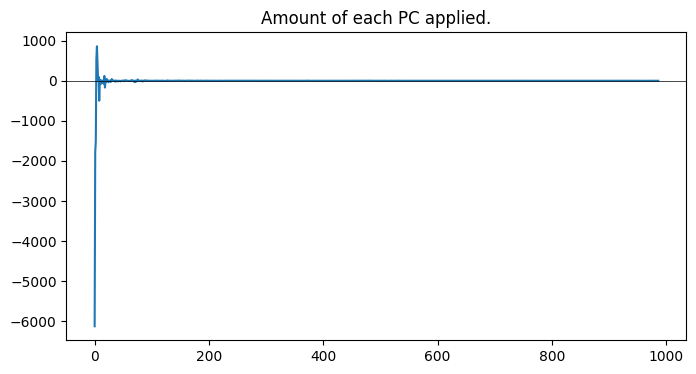

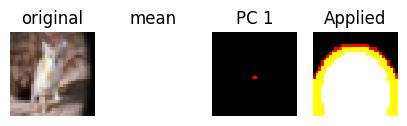

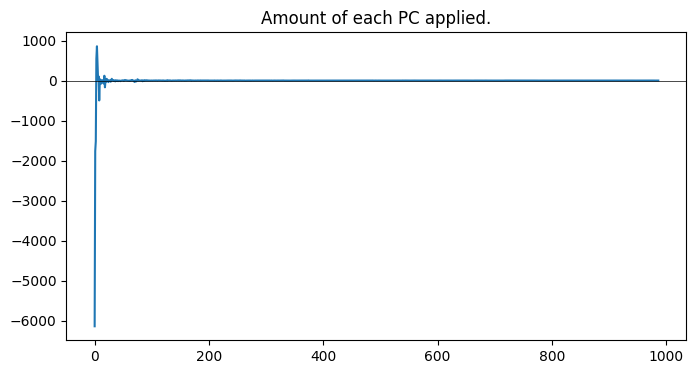

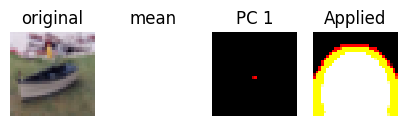

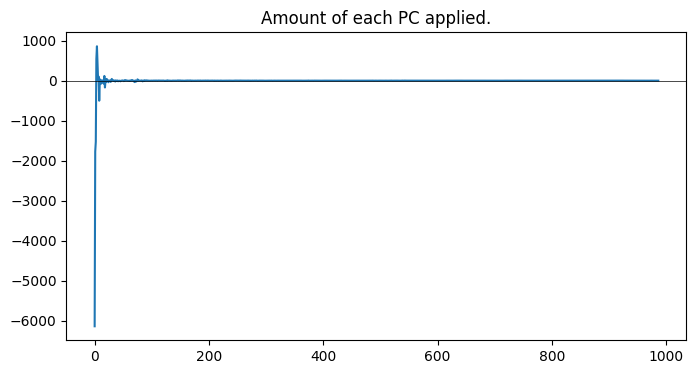

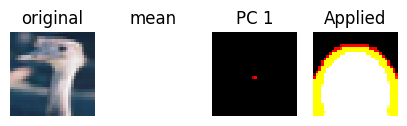

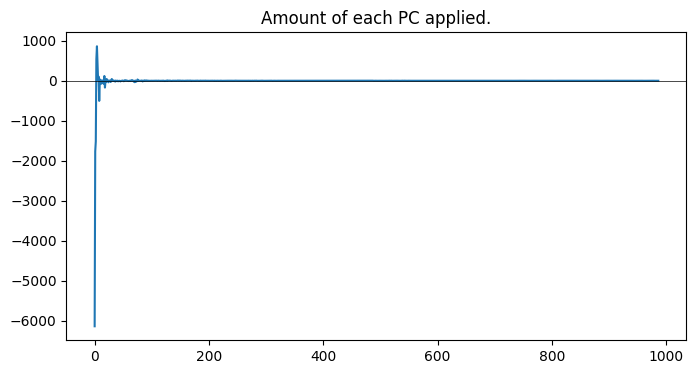

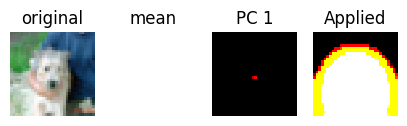

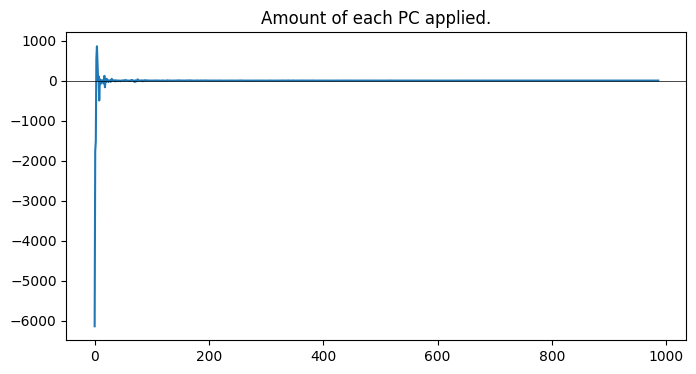

In [14]:
list_idx = [1, 127, 242, 303, 444]
for idx in list_idx:
    draw_apply_PC0(idx)

## **Nhận xét** 

Dựa vào kết quả của quá trình thực nghiệm, chúng tôi rút ra một số nhận xét như sau: 
1. Về kết quả ở ```Figure 1```, có thể thấy khi số thành phần (n_components) càng lớn, tức là số chiều dữ liệu mới càng lớn thì ảnh càng rõ nét và càng giống với ảnh gốc hơn. Bên cạnh đó với n_components= 0 thì sẽ giữ nguyên ảnh gốc ban đầu. Tuy nhiên, đối với ảnh màu trong bộ dữ liệu CIFAR10 thì số chiều dữ liệu mới phải khá lớn thì chúng ta mới có thể nhận thấy ảnh kết quả rõ nét hơn (như trong Fashion MNIST thì chỉ cần dữ liệu mới tầm 34 thì chúng ta có thể nắm bắt được thông tin ảnh kết quả rồi, nhưng đối với CIFAR10 thì cần đến khoảng gần 1000 chiều). 

2. Đối với kết quả khi thực hiện áp dụng thành phần PCA đầu tiên lên một số ảnh trong tập test, thì với chỉ số ```Amount to apply``` (đại diện cho phép chiếu của một test lên first principal component) càng cao thì ảnh kết quả khi được áp dụng PCA sẽ càng giống với ảnh gốc hơn. 

3. Trong kết quả test với một số mẫu trong tập test thì hầu như chỉ số này đều ra âm, chứng tỏ rằng khi áp dụng first components lên ảnh test thì kết quả ra rất tệ và chúng ta có thể nhận thấy ảnh kết quả (**Applied**) không thể nhận diện được thông tin nào so với ảnh gốc. 

4. Dựa trên các giá trị **PCO_min** và **PC0_max** có thể thấy biên độ nhỏ hơn cả so với trong Fashion MNIST (-0.0002, 0,0315) có thể thấy dữ liệu ít biến động và có thể rằng PC0 không mang nhiều thông tin quan trọng về đặc trưng của dữ liệu. 

5. Trong khi đó,  các giá trị **mean_img min**  và **mean_img max** (lần lượt các giá trị pixel nhỏ và lớn nhất trong hình ảnh trung bình khi áp dụng PCA) nằm trong khoảng (99,9951 , 140,2688) hẹp hơn rất nhiều so với trong Fashion MNIST, thể hiện rằng ảnh kết quả khó có thể giữ được thông tin quan trọng của hình ảnh gốc. Và chúng ta có thể thấy các kết quả của ảnh **Applied** đối với 4 mẫu test, chúng hầu như đều là giống nhau, không có sự đa dạng và cũng không giúp nắm bắt được thông tin gì so với hình ảnh gốc. 